In [1]:
import numpy as np
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
})

def sampling_coordinates(n, s):
    return (np.arange(n) - (n-1)/2) * s/n

def evaluate(x, xi, amplitudes, phases):
    return np.sum(amplitudes * np.cos(2.0 * np.pi * xi * x[:, np.newaxis] + phases), axis=-1)

def spatial_display_to_eye(x_a, x_b, z_a, z_b, z_r, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_a, z_b, z_r, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_a, z_b, z_r, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_a, z_b, z_r, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

def compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Ratios for projection of plane A and plane B to the pupil plane
    ratio_a = np.reciprocal(1.0 - z_a/z_f)
    ratio_b = np.reciprocal(1.0 - z_b/z_f)
    # Project display samples to the pupil plane
    x_a_at_p = (x_a[np.newaxis, ..., np.newaxis] - x_r[..., np.newaxis, np.newaxis] * (z_a/z_r)) * ratio_a
    x_b_at_p = (x_b[np.newaxis, np.newaxis, ...] - x_r[..., np.newaxis, np.newaxis] * (z_b/z_r)) * ratio_b
    # Compute the lower and upper bounds for each intersection of plane A intervals, plane B intervals and the pupil aperture
    lower_bound = np.maximum(np.maximum(-s_p/2, x_a_at_p - np.abs(ratio_a * w_a/2)), x_b_at_p - np.abs(ratio_b * w_b/2))
    upper_bound = np.minimum(np.minimum( s_p/2, x_a_at_p + np.abs(ratio_a * w_a/2)), x_b_at_p + np.abs(ratio_b * w_b/2))
    # Return the lengths of the intersection intervals normalized by the pupil diameter
    return np.maximum(np.subtract(upper_bound, lower_bound) / s_p, 0.0)

In [2]:
def plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f):
    n_p = 99

    x_r = sampling_coordinates(n_r, s_r)

    x_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * s_b), 99 * n_a))
    xi_ab = (np.repeat(sampling_coordinates(99 * n_a, 99 * n_a/s_a), 99 * n_b), np.tile(sampling_coordinates(99 * n_b, 99 * n_b/s_b), 99 * n_a))

    window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
    window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))
    xi_p = sampling_coordinates(n_p, n_p/s_p)
    xi_r = sampling_coordinates(n_r, n_r/s_r)

    fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

    axs[0, 0].set_title('Eye spatial domain', fontsize=14)
    axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
    axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_xticks([0])
    axs[0, 0].set_yticks([0])
    axs[0, 0].set_xlim(-15.0, 15.0)
    axs[0, 0].set_ylim(-15.0, 15.0)

    axs[0, 0].scatter(*spatial_display_to_eye(*x_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
    axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 0].plot(*spatial_display_to_eye(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot(*spatial_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 0].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')
    axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
    axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
    axs[0, 0].fill(*spatial_display_to_eye(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                                        np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')

    axs[0, 1].set_title('Eye frequency domain', fontsize=14)
    axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
    axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_xticks([0])
    axs[0, 1].set_yticks([0])
    axs[0, 1].set_xlim(-2.8, 2.8)
    axs[0, 1].set_ylim(-2.8, 2.8)

    axs[0, 1].scatter(*frequency_display_to_eye(*xi_ab, z_a, z_b, z_r, z_f), color='lfd:signal', zorder=3)
    axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', marker='x', zorder=3)
    axs[0, 1].plot(*frequency_display_to_eye(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), z_a, z_b, z_r, z_f), color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(*frequency_display_to_eye(np.tile([-100.0, 100.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), z_a, z_b, z_r, z_f), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), linestyle='dashed', color='lfd:pupil')
    axs[0, 1].plot([-100.0, 100.0], [0.0, 0.0], color='lfd:retina')

    axs[1, 0].set_title('Display spatial domain', fontsize=14)
    axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
    axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
    axs[1, 0].set_aspect('equal')
    axs[1, 0].set_xticks([0])
    axs[1, 0].set_yticks([0])
    axs[1, 0].set_xlim(-15.0, 15.0)
    axs[1, 0].set_ylim(-15.0, 15.0)

    axs[1, 0].scatter(*x_ab, color='lfd:signal', zorder=3)
    axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 0].plot(np.repeat(sampling_coordinates(99, 99 * s_a) - s_a/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
    axs[1, 0].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * s_b) - s_b/2, 3), color='lfd:signal')
    axs[1, 0].plot(*spatial_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
    axs[1, 0].fill(np.repeat(x_ab[0], 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * w_a/2, 99 * n_a * 99 * n_b),
                np.repeat(x_ab[1], 5) + np.tile(np.array([1, -1, -1, 1, np.nan]) * w_b/2, 99 * n_a * 99 * n_b), alpha=0.2, color='lfd:signal')

    axs[1, 1].set_title('Display frequency domain', fontsize=14)
    axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
    axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
    axs[1, 1].set_aspect('equal')
    axs[1, 1].set_xticks([0])
    axs[1, 1].set_yticks([0])
    axs[1, 1].set_xlim(-2.8, 2.8)
    axs[1, 1].set_ylim(-2.8, 2.8)

    axs[1, 1].scatter(*xi_ab, color='lfd:signal', zorder=3)
    axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', marker='x', zorder=3)
    axs[1, 1].plot(np.repeat(sampling_coordinates(99, 99 * n_a/s_a) - (n_a/s_a)/2, 3), np.tile([-100.0, 100.0, np.nan], 99), color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 99), np.repeat(sampling_coordinates(99, 99 * n_b/s_b) - (n_b/s_b)/2, 3), color='lfd:signal')
    axs[1, 1].plot( np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(-np.repeat(np.arange(1, 99) / w_a, 3), np.tile([-100.0, 100.0, np.nan], 98), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 98),  np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(np.tile([-100.0, 100.0, np.nan], 98), -np.repeat(np.arange(1, 99) / w_b, 3), linestyle='dashed', linewidth=3, color='lfd:signal')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[:n_p//2], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.tile([-100.0, 100.0, np.nan], n_p//2), np.repeat(xi_p[n_p//2+1:], 3), z_a, z_b, z_r, z_f), linestyle='dashed', color='lfd:pupil')
    axs[1, 1].plot(*frequency_eye_to_display(np.array([-100.0, 100.0]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')

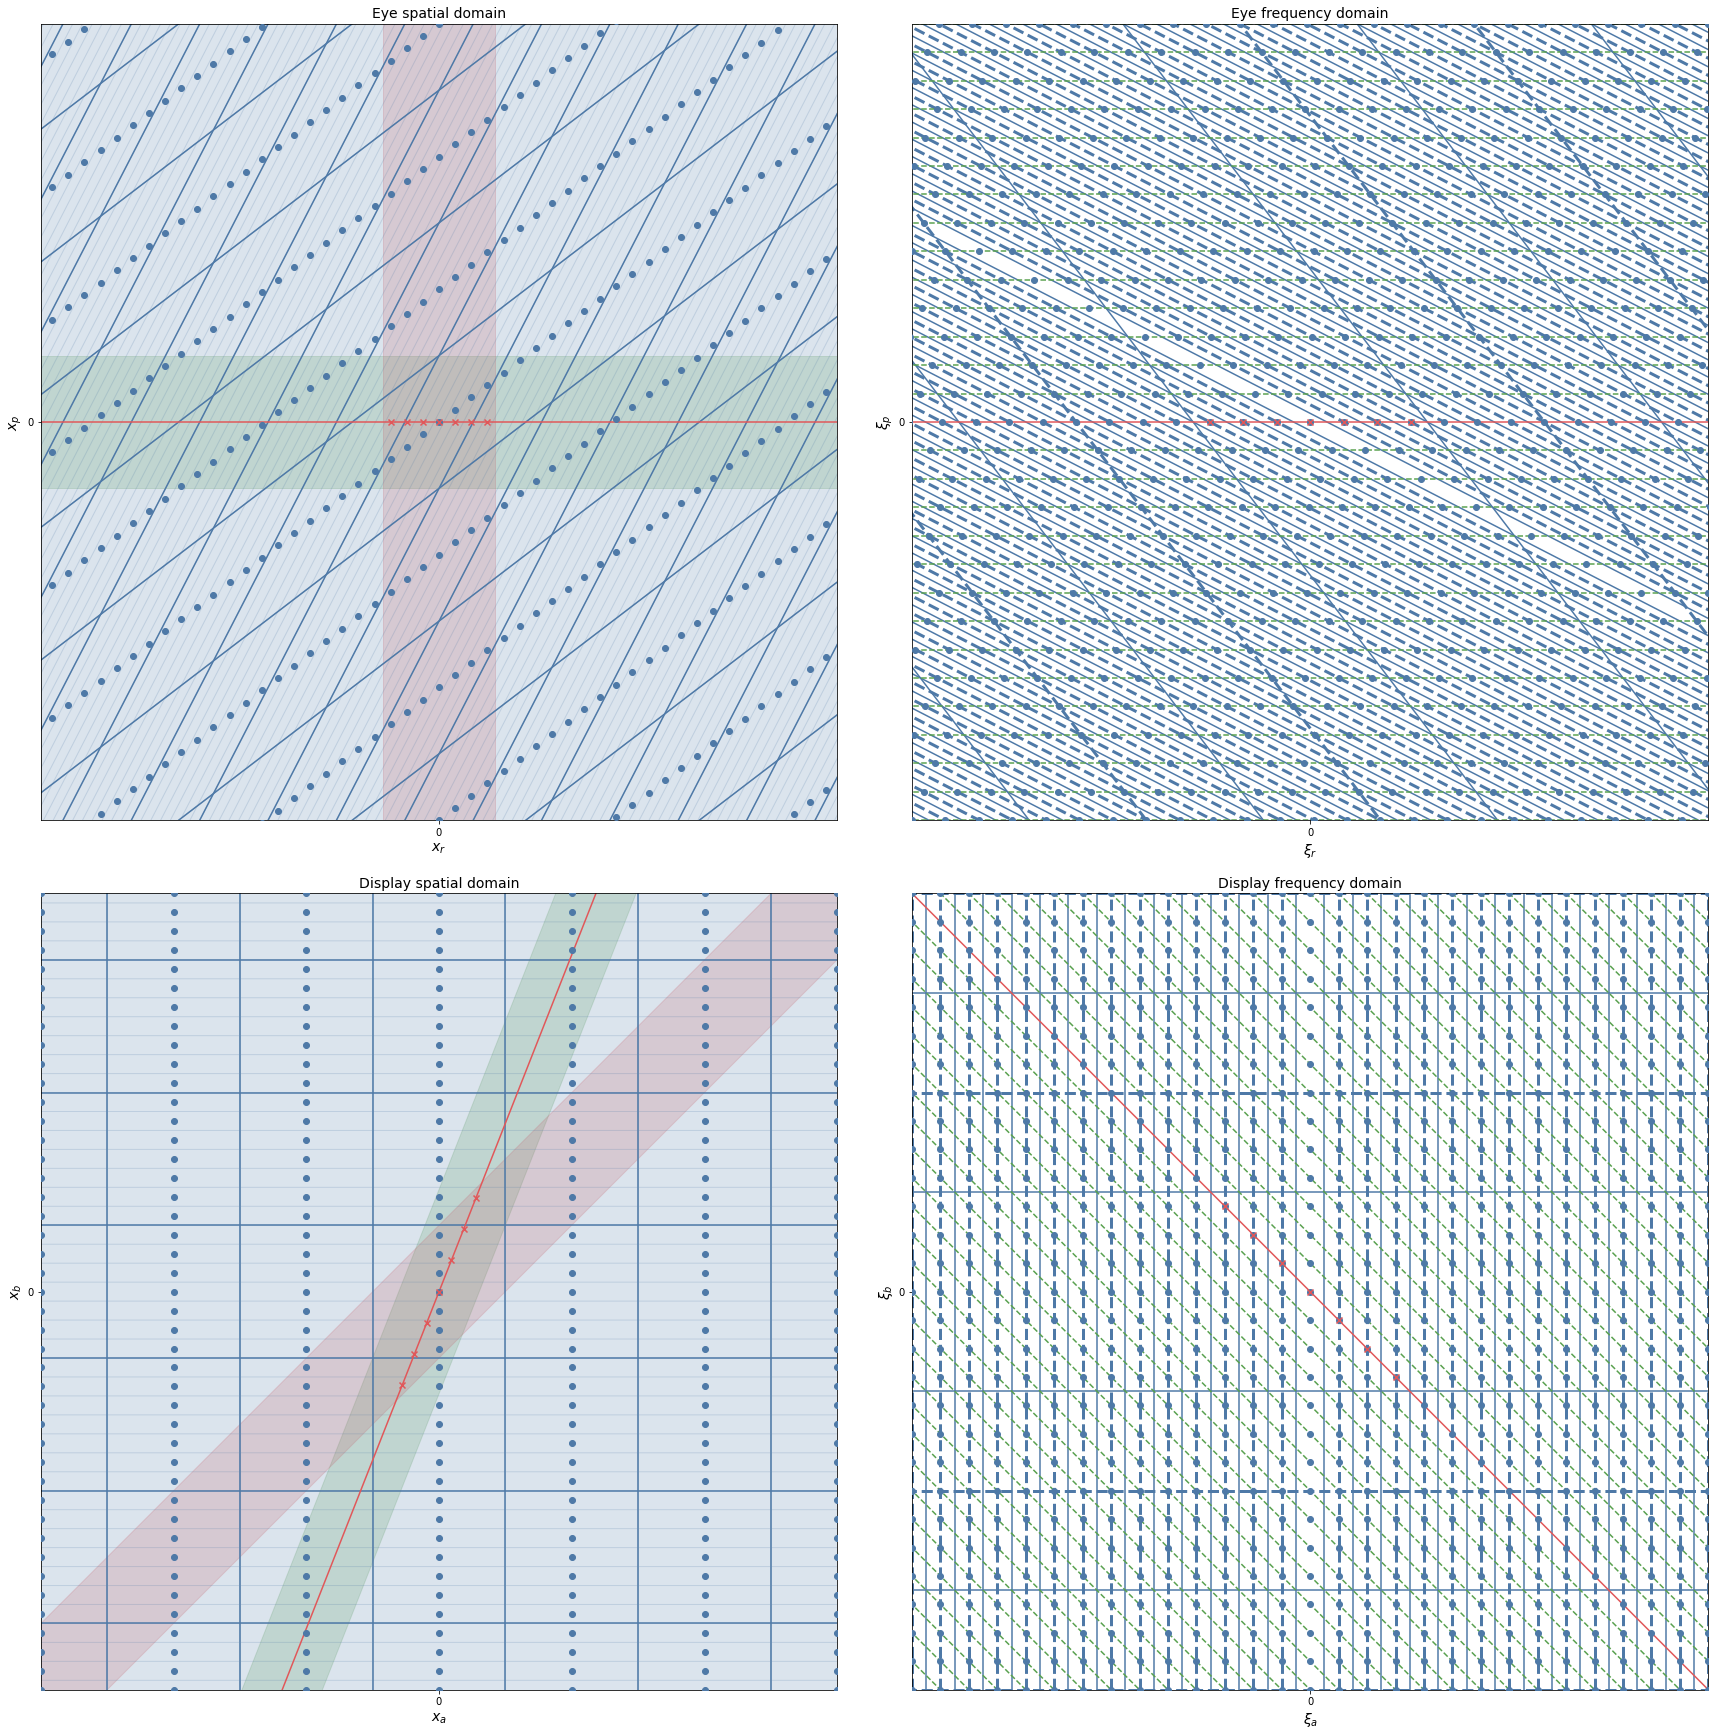

In [3]:
z_a = 13.0
z_b = 33.0
z_r = -17.0
z_f = np.inf

n_a = 1
n_b = 7
n_r = 7

s_p = 5.0

s_a = s_p
s_b = s_p

s_r = np.abs(z_r/(z_b - z_a)) * s_p

w_a = (s_a / n_a)
w_b = (s_b / n_b)

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f)

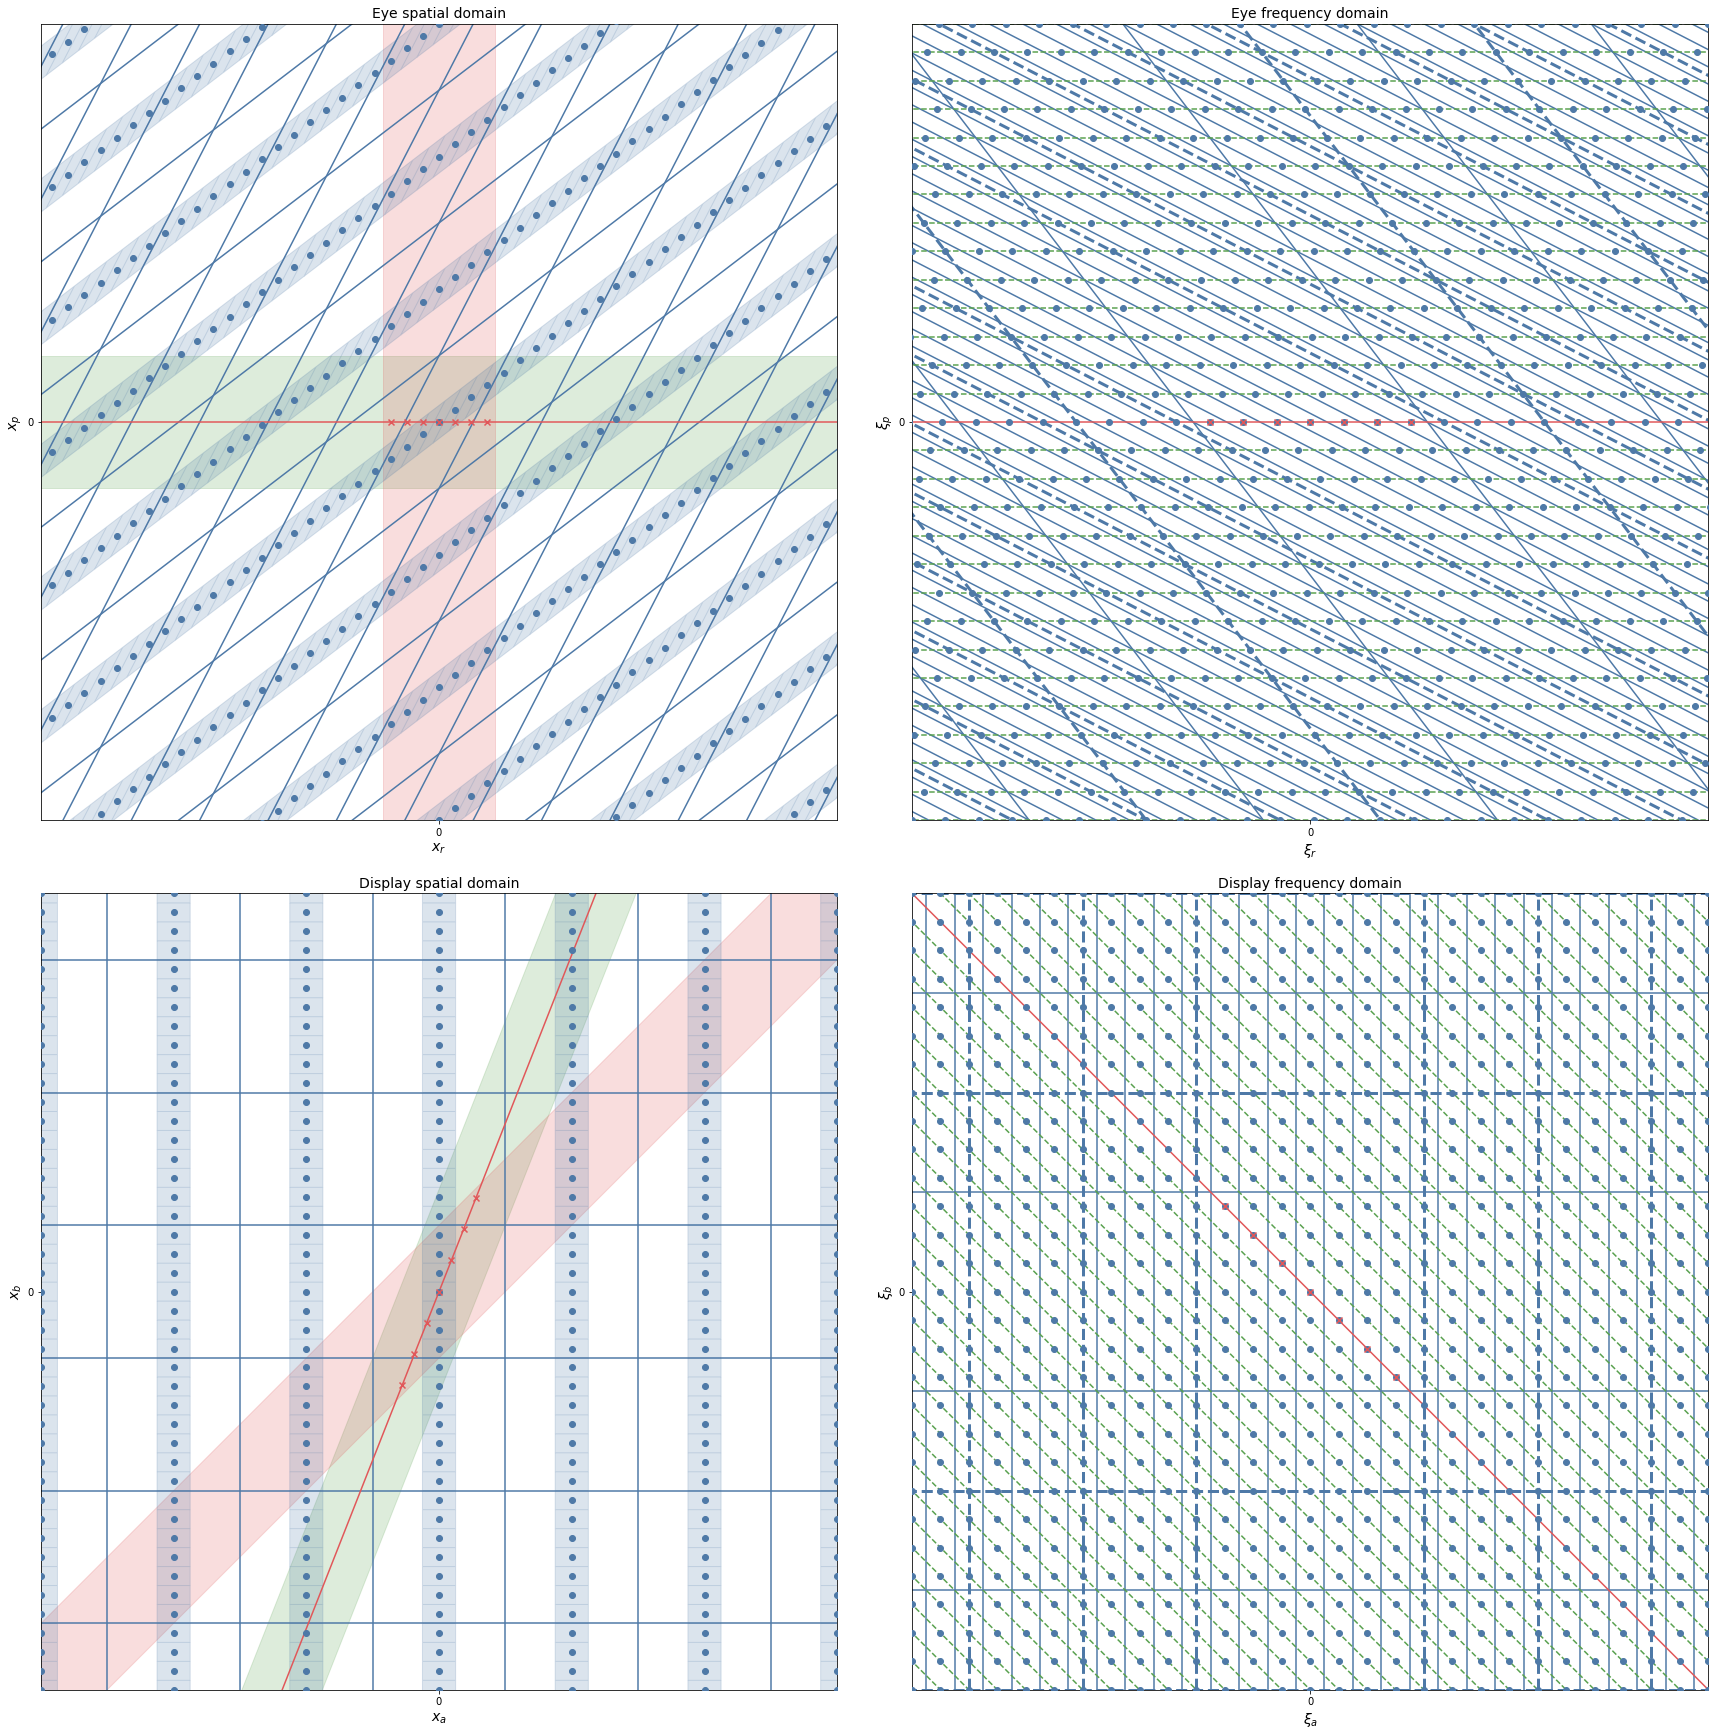

In [4]:
w_a = (s_a / n_a) / np.ceil(n_r / 2)

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f)

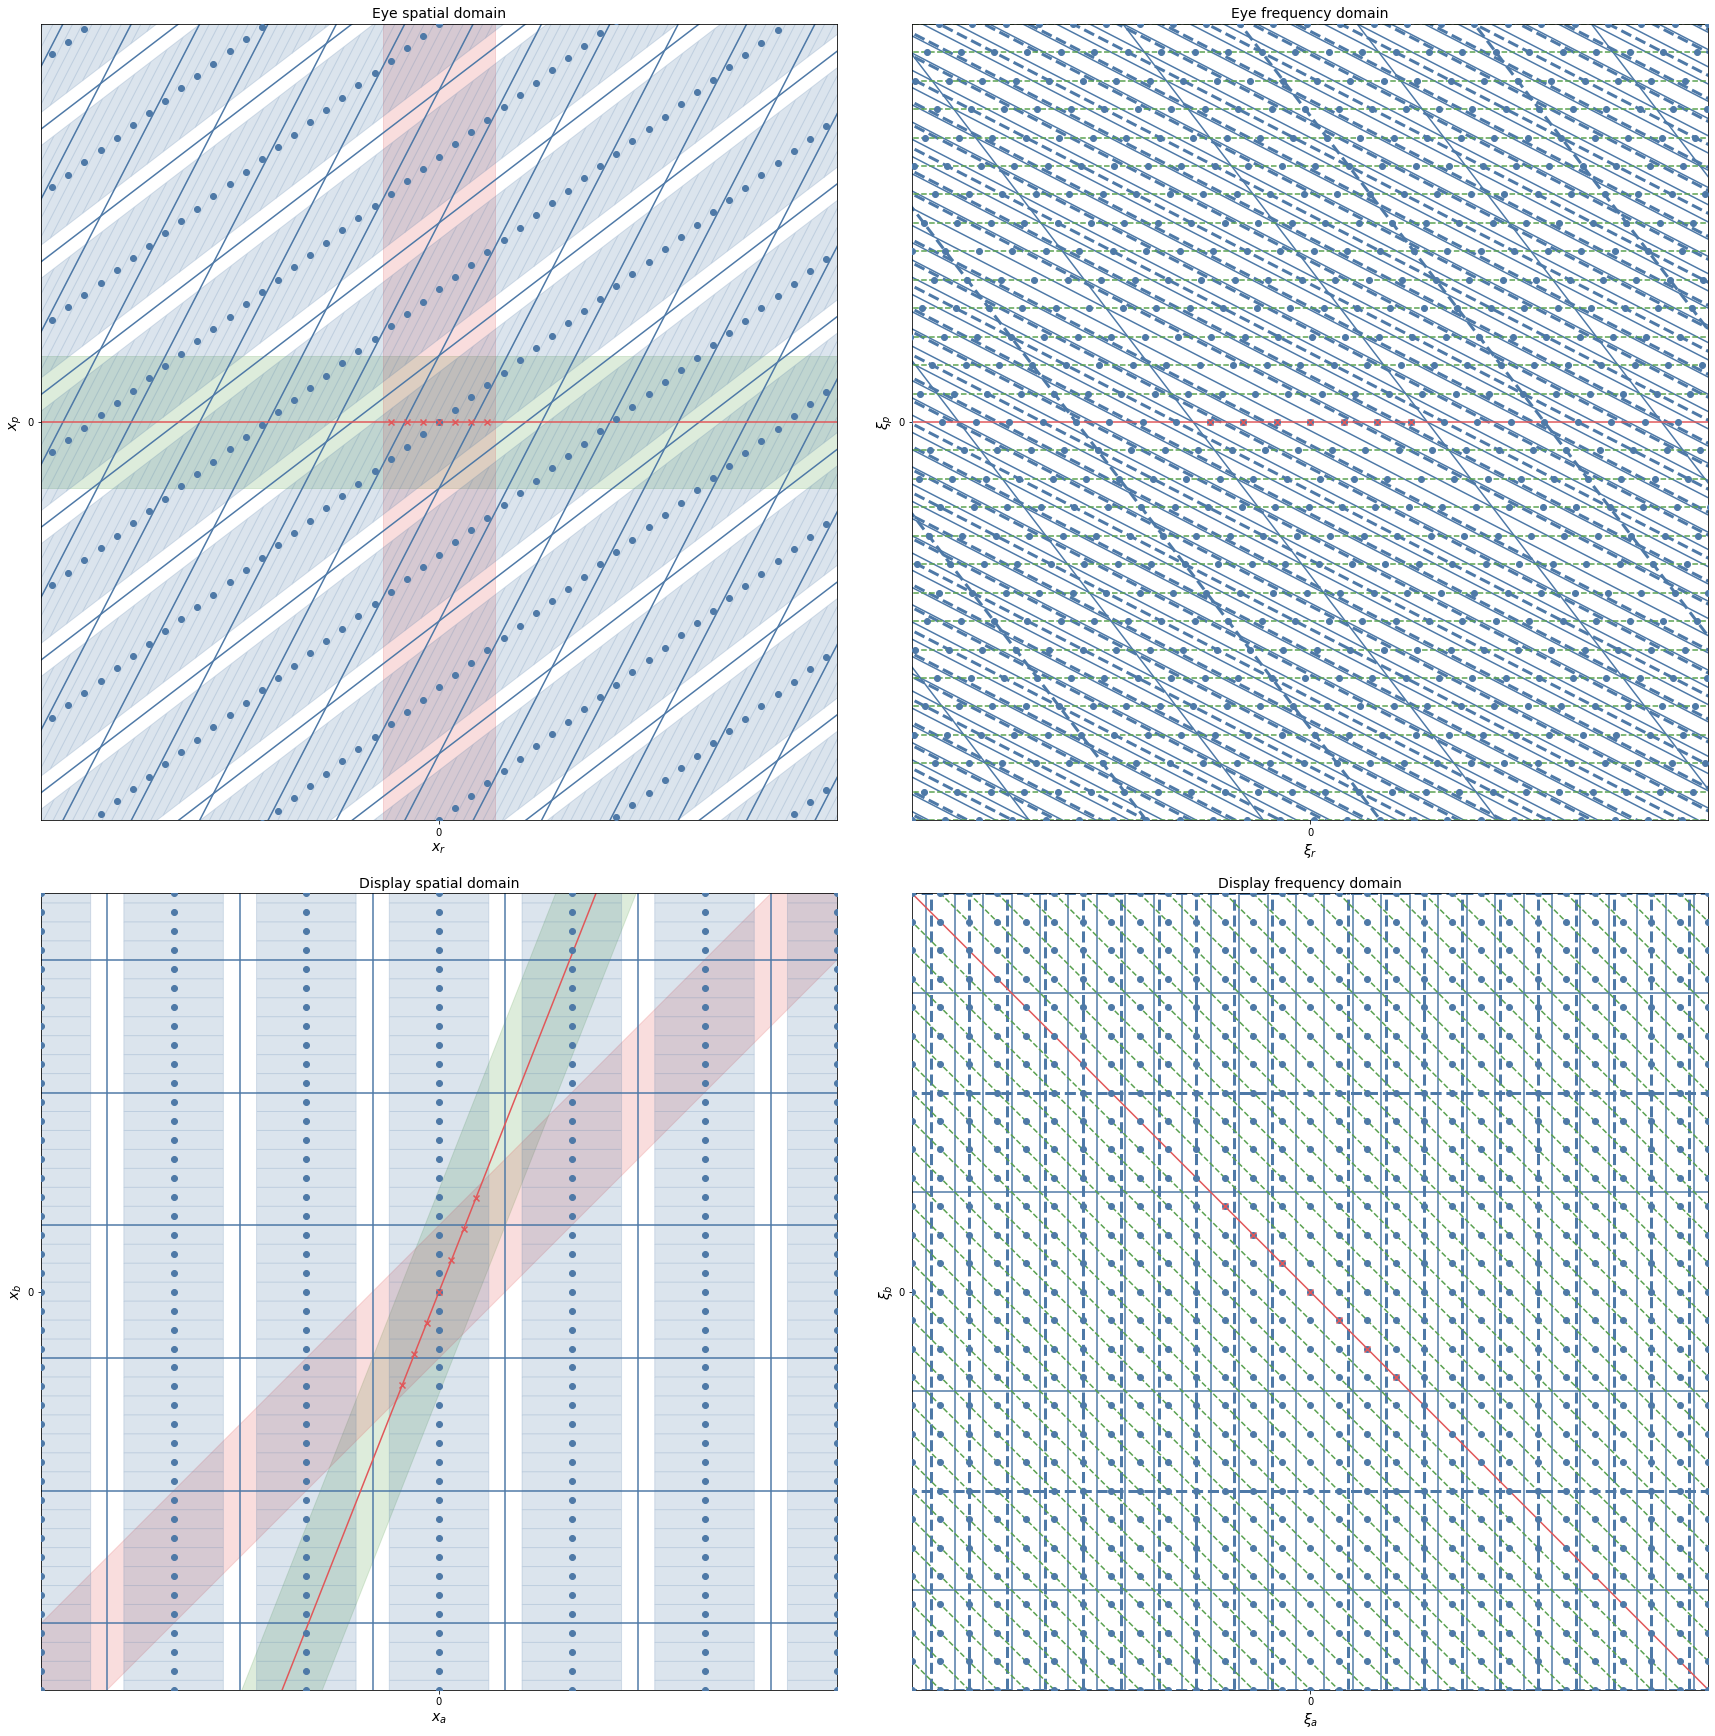

In [5]:
w_a = (s_a / n_a) * np.floor(n_r / 2) / np.ceil(n_r / 2)

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f)

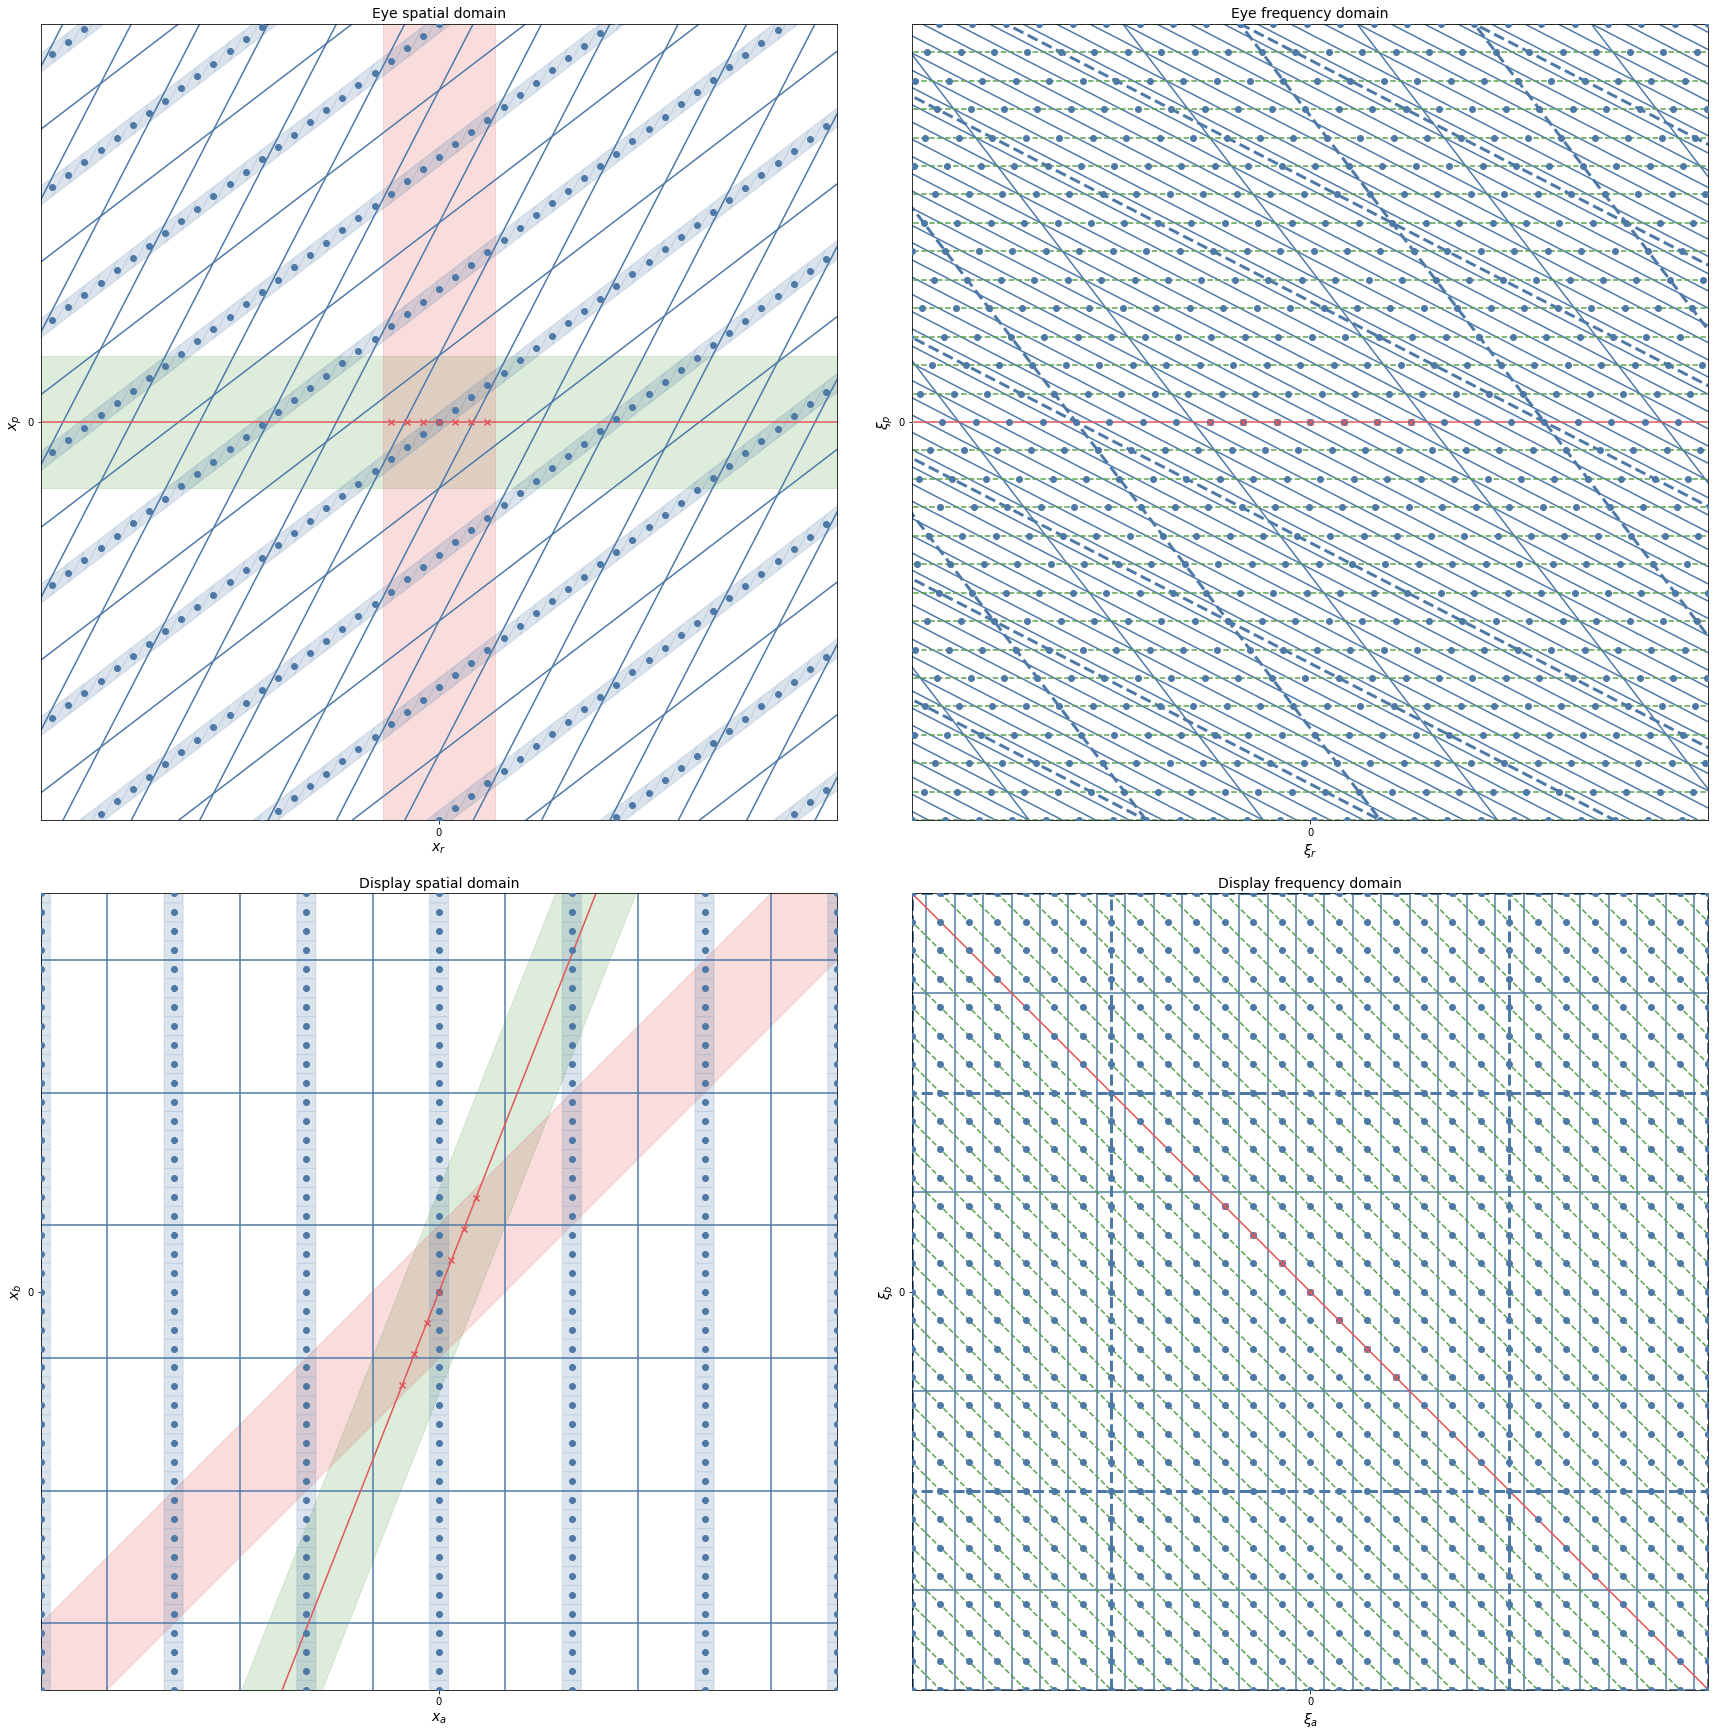

In [6]:
w_a = w_b

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, w_a, w_b, z_a, z_b, z_r, z_f)

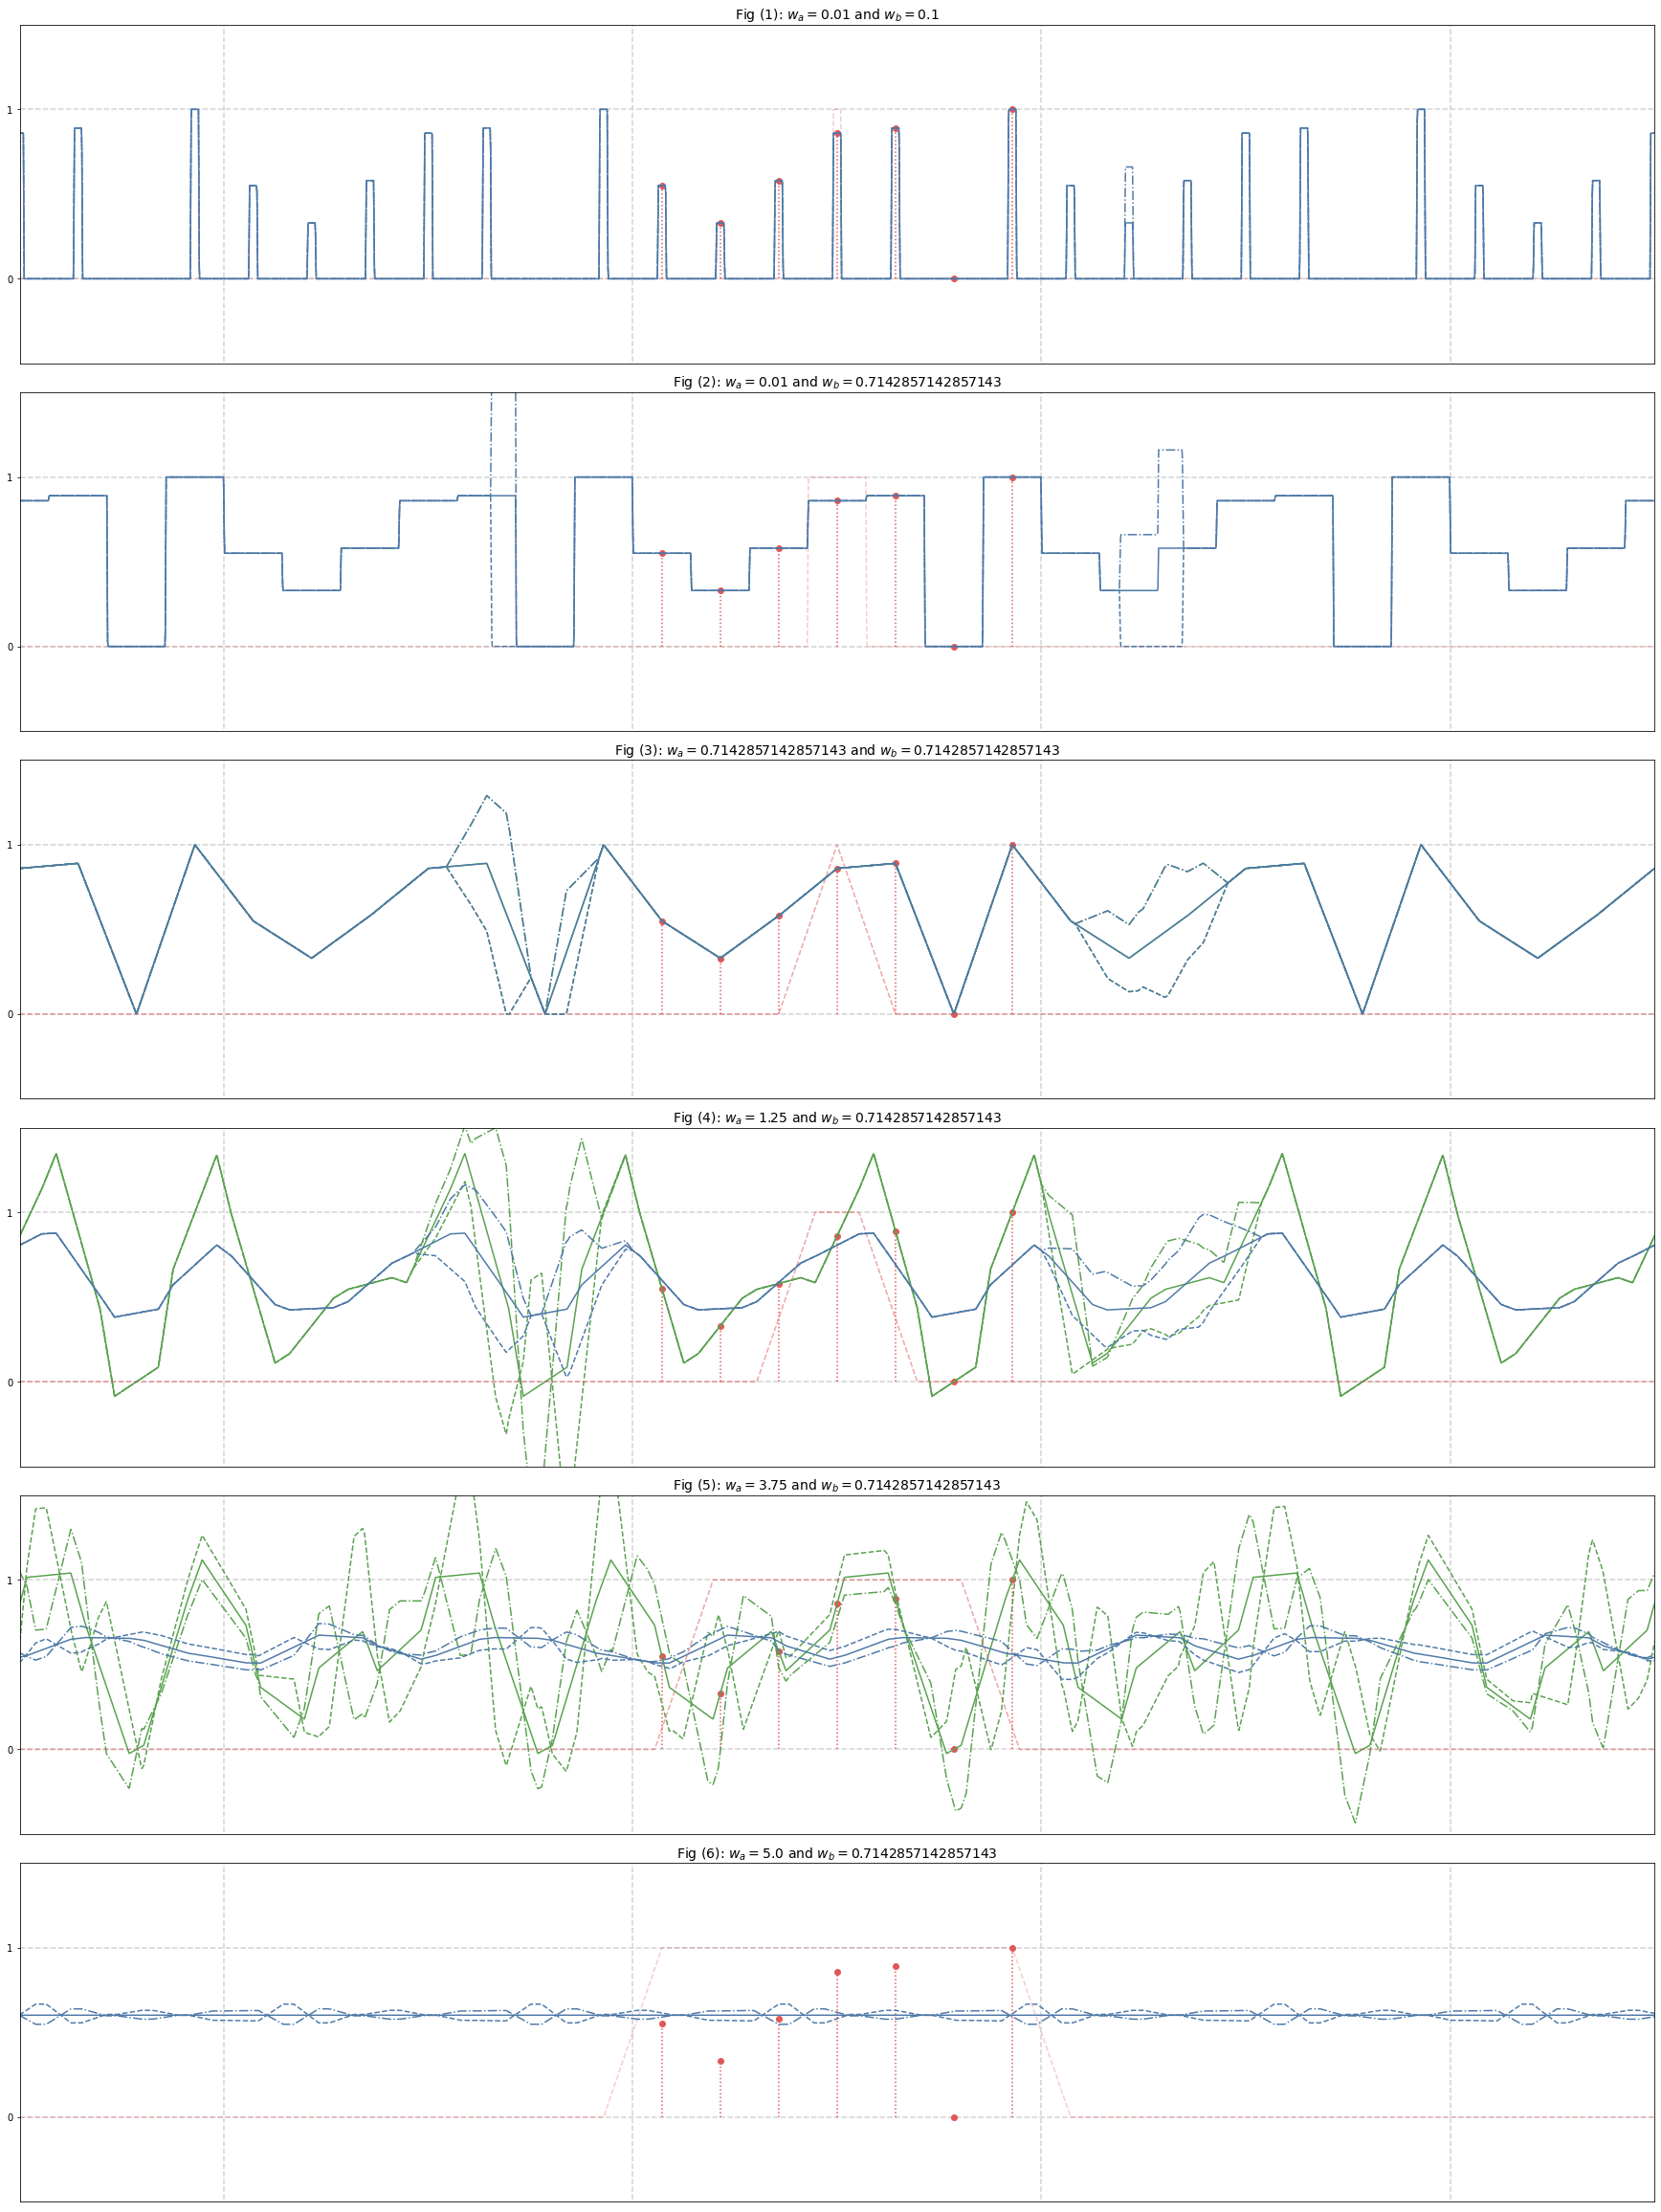

In [7]:
samples = np.array([0.55, 0.33, 0.58, 0.86, 0.89, 0.00, 1.00])
samples_ab = np.tile(np.flip(samples), (33, 33))

x_r = sampling_coordinates(5 * 999, 5 * s_r)
x_a = sampling_coordinates(33 * n_a, 33 * s_a)
x_b = sampling_coordinates(33 * n_b, 33 * s_b)

xi_b = sampling_coordinates(n_b, n_b / s_b)

fig, axs = pyplot.subplots(6, constrained_layout=True, figsize=(24, 32))

x_plot_size = 4 * s_r

for ax in axs:
    ax.set_xticks([])
    ax.set_xlim(-x_plot_size/2, x_plot_size/2)
    ax.set_yticks([0.0, 1.0])
    ax.set_ylim(-0.5, 1.5)
    ax.hlines([0.0, 1.0], -x_plot_size/2, x_plot_size/2, linestyle='dashed', color='lightgrey', zorder=-1)
    ax.vlines(np.array([-1.5, -0.5, 0.5, 1.5]) * s_r, -3, 3, linestyle='dashed', color='lightgrey', zorder=-1)
    [ln.set_color('lfd:retina') for ln in ax.stem(sampling_coordinates(n_r, s_r), samples, linefmt=':', basefmt='none')[0:2]]

w_a = 0.01
w_b = 0.1
axs[0].set_title(fr'Fig (1): $w_a = {w_a}$ and $w_b = {w_b}$', fontsize=14)

top = (s_r/s_b) * np.abs(w_a - w_b)/2
base = (s_r/s_b) * (w_a + w_b)/2
kernel = np.clip((base - np.abs(x_r)) / (base - top), 0.0, 1.0)
axs[0].plot(x_r, kernel, alpha=0.3, linestyle='dashed', color='lfd:retina')

img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.sum(samples_ab * img_tsr, axis=(1, 2))
axs[0].plot(x_r, values_r/np.amax(values_r), color='lfd:signal')
img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p*1.1, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.sum(samples_ab * img_tsr, axis=(1, 2))
axs[0].plot(x_r, values_r/np.amax(values_r), linestyle='dashdot', color='lfd:signal')
img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p*0.9, w_a, w_b, z_r, z_a, z_b, z_f)
values_r = np.sum(samples_ab * img_tsr, axis=(1, 2))
axs[0].plot(x_r, values_r/np.amax(values_r), linestyle='dashed', color='lfd:signal')

def plot_retina(idx, axs, w_a, w_b, values_ab, color):
    axs[idx].set_title(fr'Fig ({idx+1}): $w_a = {w_a}$ and $w_b = {w_b}$', fontsize=14)

    top = (s_r/s_b) * np.abs(w_a - w_b)/2
    base = (s_r/s_b) * (w_a + w_b)/2
    kernel = np.clip((base - np.abs(x_r)) / (base - top), 0.0, 1.0)
    axs[idx].plot(x_r, kernel, alpha=0.3, linestyle='dashed', color='lfd:retina')

    img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p, w_a, w_b, z_r, z_a, z_b, z_f)
    values_r = np.sum(values_ab * img_tsr, axis=(1, 2))
    axs[idx].plot(x_r, values_r * np.mean(samples) / np.mean(values_r[2*999:3*999]), color=color)
    img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p*1.1, w_a, w_b, z_r, z_a, z_b, z_f)
    values_r = np.sum(values_ab * img_tsr, axis=(1, 2))
    axs[idx].plot(x_r, values_r * np.mean(samples) / np.mean(values_r[2*999:3*999]), linestyle='dashdot', color=color)
    img_tsr = compute_imaging_tensor(x_r, x_a, x_b, s_p*0.9, w_a, w_b, z_r, z_a, z_b, z_f)
    values_r = np.sum(values_ab * img_tsr, axis=(1, 2))
    axs[idx].plot(x_r, values_r * np.mean(samples) / np.mean(values_r[2*999:3*999]), linestyle='dashed', color=color)

w_b = (s_b / n_b)

w_a = 0.01
plot_retina(1, axs, w_a, w_b, samples_ab, 'lfd:signal')

w_a = w_b
top = np.abs(w_a - w_b)/2
base = (w_a + w_b)/2
values_ab = np.tile(np.flip(scipy_fft.irfft(scipy_fft.rfft(samples) / scipy_fft.rfft(np.clip((base - np.abs(scipy_fft.ifftshift(sampling_coordinates(n_b, s_b)))) / (base - top), 0.0, 1.0)), n_b)), (33, 33))
plot_retina(2, axs, w_a, w_b, values_ab, 'lfd:pupil')
plot_retina(2, axs, w_a, w_b, samples_ab, 'lfd:signal')

w_a = (s_a / n_a) / np.ceil(n_r / 2)
top = np.abs(w_a - w_b)/2
base = (w_a + w_b)/2
values_ab = np.tile(np.flip(scipy_fft.irfft(scipy_fft.rfft(samples) / scipy_fft.rfft(np.clip((base - np.abs(scipy_fft.ifftshift(sampling_coordinates(n_b, s_b)))) / (base - top), 0.0, 1.0)), n_b)), (33, 33))
plot_retina(3, axs, w_a, w_b, values_ab, 'lfd:pupil')
plot_retina(3, axs, w_a, w_b, samples_ab, 'lfd:signal')

w_a = (s_a / n_a) * np.floor(n_r / 2) / np.ceil(n_r / 2)
top = np.abs(w_a - w_b)/2
base = (w_a + w_b)/2
values_ab = np.tile(np.flip(scipy_fft.irfft(scipy_fft.rfft(samples) / scipy_fft.rfft(np.clip((base - np.abs(scipy_fft.ifftshift(sampling_coordinates(n_b, s_b)))) / (base - top), 0.0, 1.0)), n_b)), (33, 33))
plot_retina(4, axs, w_a, w_b, values_ab, 'lfd:pupil')
plot_retina(4, axs, w_a, w_b, samples_ab, 'lfd:signal')

w_a = (s_a / n_a)
plot_retina(5, axs, w_a, w_b, samples_ab, 'lfd:signal')